In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Nifty 50 tickers as of July 2025
NIFTY50_TICKERS = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'ICICIBANK.NS',
    'HINDUNILVR.NS', 'ITC.NS', 'KOTAKBANK.NS', 'LT.NS', 'SBIN.NS',
    'BHARTIARTL.NS', 'AXISBANK.NS', 'BAJAJFINSV.NS', 'HCLTECH.NS', 'MARUTI.NS',
    'SUNPHARMA.NS', 'ULTRACEMCO.NS', 'NESTLEIND.NS', 'BAJFINANCE.NS', 'WIPRO.NS',
    'ASIANPAINT.NS', 'POWERGRID.NS', 'TITAN.NS', 'DIVISLAB.NS', 'HDFCLIFE.NS',
    'ONGC.NS', 'TECHM.NS', 'CIPLA.NS', 'ADANIGREEN.NS', 'BAJAJ-AUTO.NS',
    'GRASIM.NS', 'HDFCAMC.NS', 'TATASTEEL.NS', 'COALINDIA.NS', 'BRITANNIA.NS',
    'EICHERMOT.NS', 'JSWSTEEL.NS', 'ADANIPORTS.NS', 'M&M.NS', 'SHREECEM.NS',
    'HEROMOTOCO.NS', 'BPCL.NS', 'INDUSINDBK.NS', 'DRREDDY.NS', 'SBILIFE.NS',
    'HINDALCO.NS', 'ICICIPRULI.NS', 'GAIL.NS', 'NTPC.NS', 'UPL.NS'
]



In [ ]:
def download_data(ticker):
    try:
        df = yf.download(ticker, start="2019-01-01", end=pd.Timestamp.today().strftime('%Y-%m-%d'), interval='1d')
        df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
        return df
    except Exception as e:
        print(f"Failed to download data for {ticker}: {e}")
        return None



In [ ]:
def prepare_data(df, seq_len=60):
    df = df.fillna(method='ffill').fillna(method='bfill')
    data = df[['Close']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    X, y = [], []
    for i in range(seq_len, len(scaled_data)):
        X.append(scaled_data[i-seq_len:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1]))
    return X, y, scaler



In [ ]:
def build_xgb_model(trainX, trainY, testX):
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    xgb_model.fit(trainX, trainY)
    return xgb_model.predict(testX)



In [ ]:
def build_rf_model(trainX, trainY, testX):
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(trainX, trainY)
    return rf.predict(testX)



In [ ]:
def build_lr_baseline(trainX, trainY, testX):
    lr_model = LinearRegression()
    lr_model.fit(trainX, trainY)
    return lr_model.predict(testX)



In [ ]:
results = []
PLOTS = {}



In [ ]:
for ticker in NIFTY50_TICKERS:
    print(f"\nProcessing {ticker} ...")
    df = download_data(ticker)
    if df is None or len(df) < 100:
        print(f"Insufficient data for {ticker}, skipping.")
        continue

    X, y, scaler = prepare_data(df)
    split_idx = int(len(X) * 0.8)
    trainX, testX = X[:split_idx], X[split_idx:]
    trainY, testY = y[:split_idx], y[split_idx:]

    # XGBoost
    y_pred_xgb = build_xgb_model(trainX, trainY, testX)
    y_pred_xgb_actual = scaler.inverse_transform(y_pred_xgb.reshape(-1, 1)).flatten()
    testY_actual = scaler.inverse_transform(testY.reshape(-1, 1)).flatten()
    rmse_xgb = np.sqrt(mean_squared_error(testY_actual, y_pred_xgb_actual))

    # Random Forest
    y_pred_rf = build_rf_model(trainX, trainY, testX)
    y_pred_rf_actual = scaler.inverse_transform(y_pred_rf.reshape(-1, 1)).flatten()
    rmse_rf = np.sqrt(mean_squared_error(testY_actual, y_pred_rf_actual))

    # Linear Regression
    y_pred_lr = build_lr_baseline(trainX, trainY, testX)
    y_pred_lr_actual = scaler.inverse_transform(y_pred_lr.reshape(-1, 1)).flatten()
    rmse_lr = np.sqrt(mean_squared_error(testY_actual, y_pred_lr_actual))

    # Save results
    results.append({
        'Ticker': ticker,
        'RMSE_XGB': rmse_xgb,
        'RMSE_RF': rmse_rf,
        'RMSE_LR': rmse_lr,
        'Best_Model': min(
            ('XGBoost', rmse_xgb),
            ('RandomForest', rmse_rf),
            ('LinearRegression', rmse_lr),
            key=lambda x: x[1]
        )[0]
    })

    # Save data for plotting (for all stocks)
    PLOTS[ticker] = {
        'Dates': df.index[-len(testY_actual):],
        'Actual': testY_actual,
        'XGB_Pred': y_pred_xgb_actual,
        'RF_Pred': y_pred_rf_actual,
        'LR_Pred': y_pred_lr_actual
    }
    print(f"Done: XGB RMSE={rmse_xgb:.2f}, RF RMSE={rmse_rf:.2f}, LR RMSE={rmse_lr:.2f}")




Processing RELIANCE.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=47.18, RF RMSE=40.38, LR RMSE=19.90

Processing TCS.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=211.40, RF RMSE=218.72, LR RMSE=53.73

Processing HDFCBANK.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=169.02, RF RMSE=174.48, LR RMSE=22.44

Processing INFY.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=109.59, RF RMSE=91.70, LR RMSE=26.40

Processing ICICIBANK.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=223.51, RF RMSE=218.86, LR RMSE=16.43

Processing HINDUNILVR.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=116.42, RF RMSE=88.83, LR RMSE=32.56

Processing ITC.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=25.24, RF RMSE=25.20, LR RMSE=5.37

Processing KOTAKBANK.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=61.13, RF RMSE=46.09, LR RMSE=29.81

Processing LT.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=102.76, RF RMSE=100.15, LR RMSE=64.32

Processing SBIN.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=64.36, RF RMSE=62.37, LR RMSE=14.15

Processing BHARTIARTL.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=430.46, RF RMSE=431.31, LR RMSE=23.06

Processing AXISBANK.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=86.40, RF RMSE=84.44, LR RMSE=17.92

Processing BAJAJFINSV.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=128.24, RF RMSE=99.96, LR RMSE=29.47

Processing HCLTECH.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=173.02, RF RMSE=165.67, LR RMSE=26.99

Processing MARUTI.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=630.53, RF RMSE=502.73, LR RMSE=170.46

Processing SUNPHARMA.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=198.41, RF RMSE=157.62, LR RMSE=21.91

Processing ULTRACEMCO.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=1521.07, RF RMSE=1451.20, LR RMSE=170.36

Processing NESTLEIND.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=46.13, RF RMSE=48.07, LR RMSE=29.16

Processing BAJFINANCE.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=76.77, RF RMSE=63.56, LR RMSE=13.31

Processing WIPRO.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=6.03, RF RMSE=5.40, LR RMSE=4.92

Processing ASIANPAINT.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=55.65, RF RMSE=49.79, LR RMSE=35.97

Processing POWERGRID.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=52.53, RF RMSE=38.03, LR RMSE=5.85

Processing TITAN.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=118.58, RF RMSE=131.23, LR RMSE=51.94

Processing DIVISLAB.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=1009.92, RF RMSE=904.37, LR RMSE=97.09

Processing HDFCLIFE.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=29.83, RF RMSE=24.13, LR RMSE=10.24

Processing ONGC.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=25.40, RF RMSE=20.65, LR RMSE=6.20

Processing TECHM.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=74.93, RF RMSE=58.95, LR RMSE=25.23

Processing CIPLA.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=118.43, RF RMSE=82.08, LR RMSE=22.31

Processing ADANIGREEN.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=54.26, RF RMSE=54.64, LR RMSE=50.39

Processing BAJAJ-AUTO.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=1008.99, RF RMSE=1039.85, LR RMSE=177.39

Processing GRASIM.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=370.64, RF RMSE=363.40, LR RMSE=39.11

Processing HDFCAMC.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=769.84, RF RMSE=718.66, LR RMSE=91.03

Processing TATASTEEL.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=7.18, RF RMSE=7.70, LR RMSE=3.00

Processing COALINDIA.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=40.55, RF RMSE=32.76, LR RMSE=8.98

Processing BRITANNIA.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=477.70, RF RMSE=452.78, LR RMSE=71.29

Processing EICHERMOT.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=916.41, RF RMSE=839.07, LR RMSE=78.78

Processing JSWSTEEL.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=110.77, RF RMSE=116.54, LR RMSE=16.56

Processing ADANIPORTS.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=114.38, RF RMSE=93.01, LR RMSE=34.56

Processing M&M.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=879.22, RF RMSE=862.34, LR RMSE=57.12

Processing SHREECEM.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=673.41, RF RMSE=618.16, LR RMSE=394.66

Processing HEROMOTOCO.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=530.37, RF RMSE=530.14, LR RMSE=75.24

Processing BPCL.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=36.34, RF RMSE=24.34, LR RMSE=6.36

Processing INDUSINDBK.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=32.59, RF RMSE=32.48, LR RMSE=28.62

Processing DRREDDY.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=75.70, RF RMSE=65.26, LR RMSE=16.54

Processing SBILIFE.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=178.54, RF RMSE=190.88, LR RMSE=24.70

Processing HINDALCO.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=114.89, RF RMSE=80.67, LR RMSE=12.74

Processing ICICIPRULI.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=33.74, RF RMSE=30.28, LR RMSE=10.50

Processing GAIL.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=15.38, RF RMSE=15.19, LR RMSE=5.04

Processing NTPC.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=32.22, RF RMSE=31.11, LR RMSE=7.59

Processing UPL.NS ...


[*********************100%***********************]  1 of 1 completed


Done: XGB RMSE=12.98, RF RMSE=11.93, LR RMSE=10.61


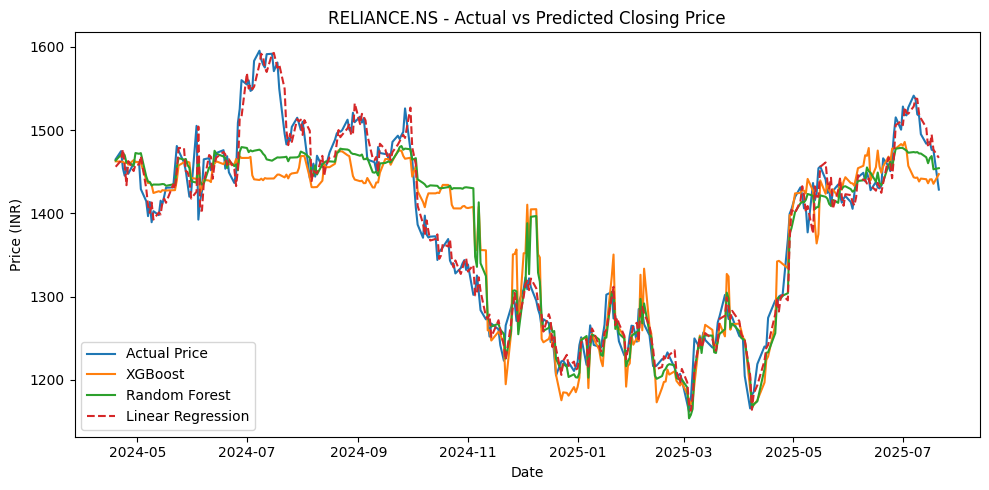

In [ ]:
#Visualization for RELIANCE.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['RELIANCE.NS']['Dates'], PLOTS['RELIANCE.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['RELIANCE.NS']['Dates'], PLOTS['RELIANCE.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['RELIANCE.NS']['Dates'], PLOTS['RELIANCE.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['RELIANCE.NS']['Dates'], PLOTS['RELIANCE.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("RELIANCE.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()




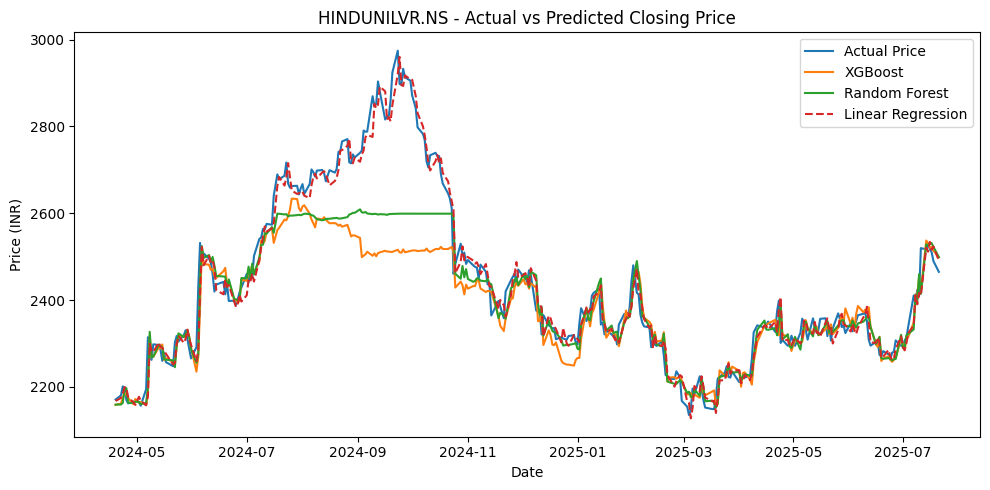

In [ ]:
#Visualization for RELIANCE.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['HINDUNILVR.NS']['Dates'], PLOTS['HINDUNILVR.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['HINDUNILVR.NS']['Dates'], PLOTS['HINDUNILVR.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['HINDUNILVR.NS']['Dates'], PLOTS['HINDUNILVR.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['HINDUNILVR.NS']['Dates'], PLOTS['HINDUNILVR.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("HINDUNILVR.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



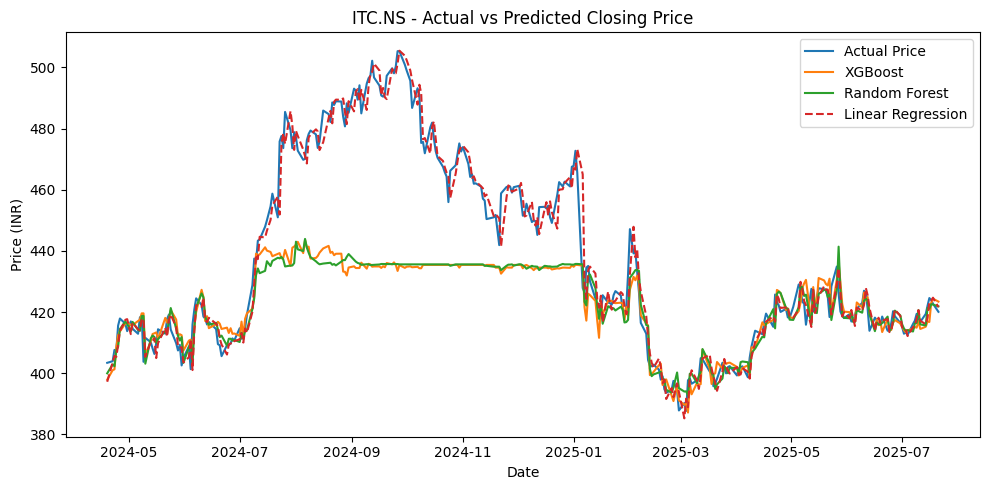

In [ ]:
#Visualization for ITC.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['ITC.NS']['Dates'], PLOTS['ITC.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['ITC.NS']['Dates'], PLOTS['ITC.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['ITC.NS']['Dates'], PLOTS['ITC.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['ITC.NS']['Dates'], PLOTS['ITC.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("ITC.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



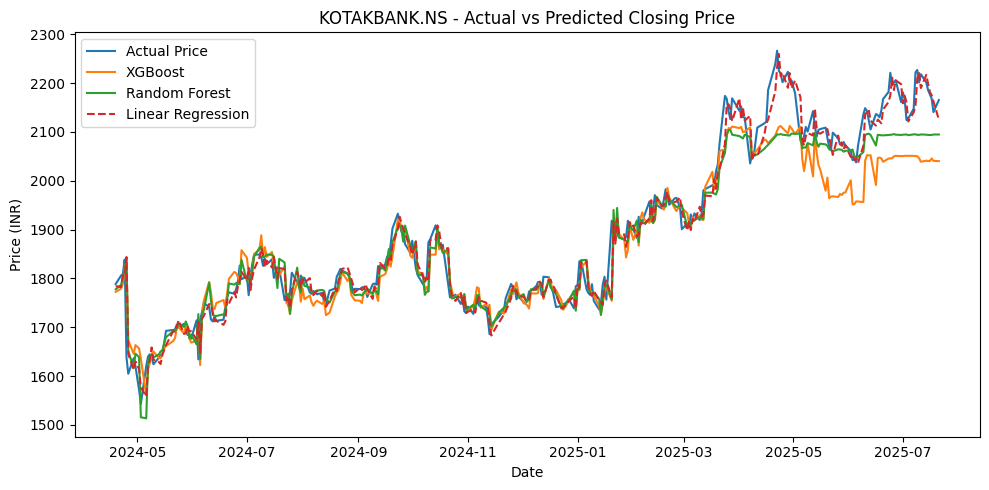

In [ ]:
#Visualization for KOTAKBANK.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['KOTAKBANK.NS']['Dates'], PLOTS['KOTAKBANK.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['KOTAKBANK.NS']['Dates'], PLOTS['KOTAKBANK.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['KOTAKBANK.NS']['Dates'], PLOTS['KOTAKBANK.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['KOTAKBANK.NS']['Dates'], PLOTS['KOTAKBANK.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("KOTAKBANK.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



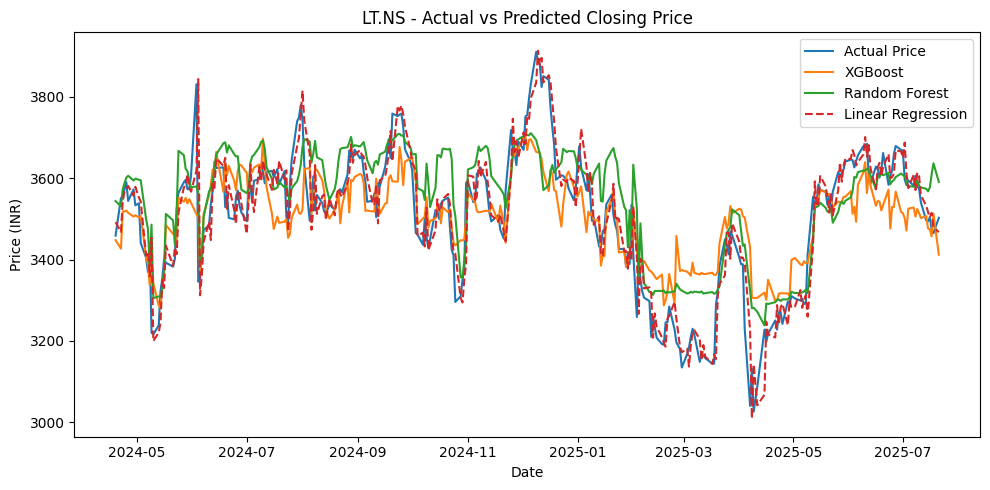

In [ ]:
#Visualization for LT.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['LT.NS']['Dates'], PLOTS['LT.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['LT.NS']['Dates'], PLOTS['LT.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['LT.NS']['Dates'], PLOTS['LT.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['LT.NS']['Dates'], PLOTS['LT.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("LT.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



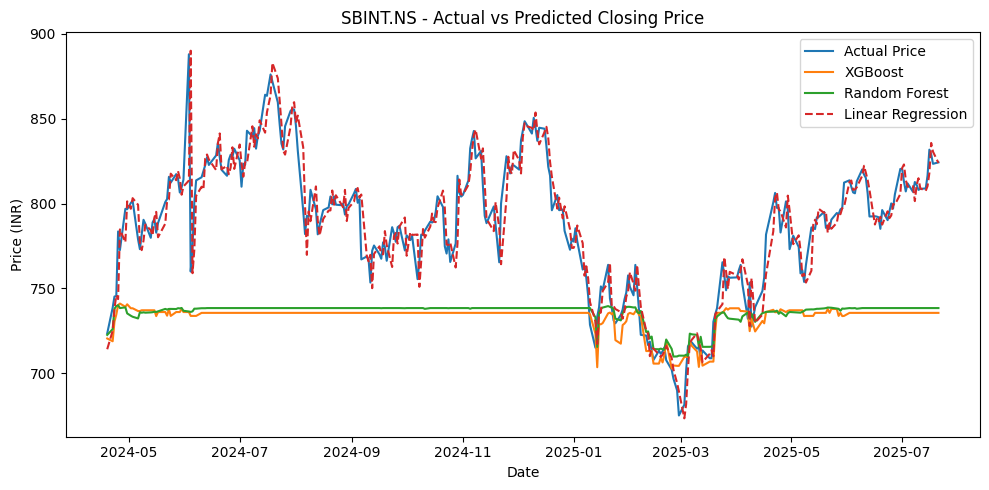

In [ ]:
#Visualization for SBIN.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['SBIN.NS']['Dates'], PLOTS['SBIN.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['SBIN.NS']['Dates'], PLOTS['SBIN.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['SBIN.NS']['Dates'], PLOTS['SBIN.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['SBIN.NS']['Dates'], PLOTS['SBIN.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("SBIN.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



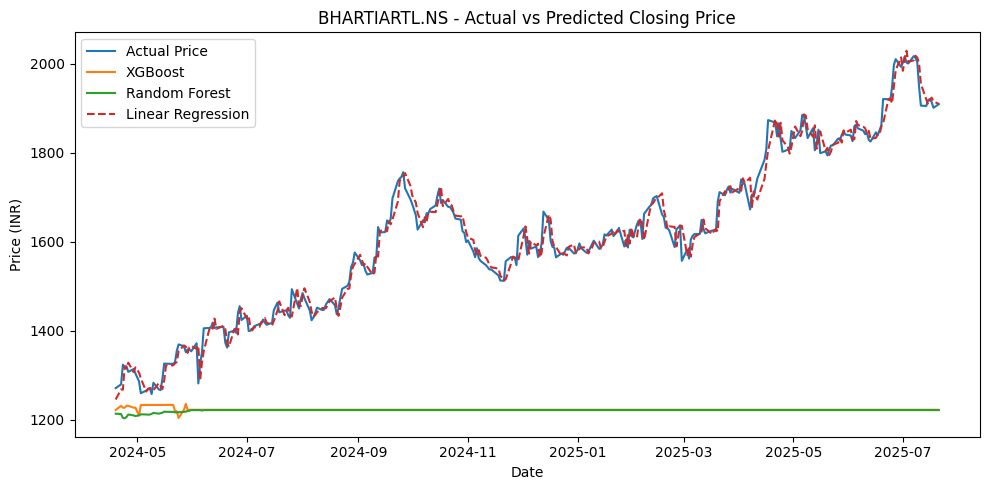

In [ ]:
#Visualization for BHARTIARTL.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['BHARTIARTL.NS']['Dates'], PLOTS['BHARTIARTL.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['BHARTIARTL.NS']['Dates'], PLOTS['BHARTIARTL.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['BHARTIARTL.NS']['Dates'], PLOTS['BHARTIARTL.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['BHARTIARTL.NS']['Dates'], PLOTS['BHARTIARTL.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("BHARTIARTL.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



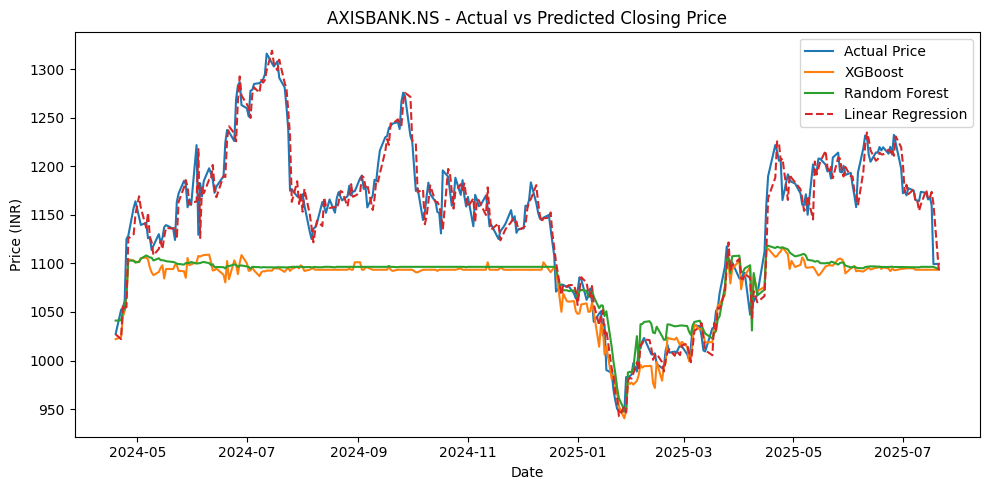

In [ ]:
#Visualization for AXISBANK.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['AXISBANK.NS']['Dates'], PLOTS['AXISBANK.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['AXISBANK.NS']['Dates'], PLOTS['AXISBANK.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['AXISBANK.NS']['Dates'], PLOTS['AXISBANK.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['AXISBANK.NS']['Dates'], PLOTS['AXISBANK.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("AXISBANK.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



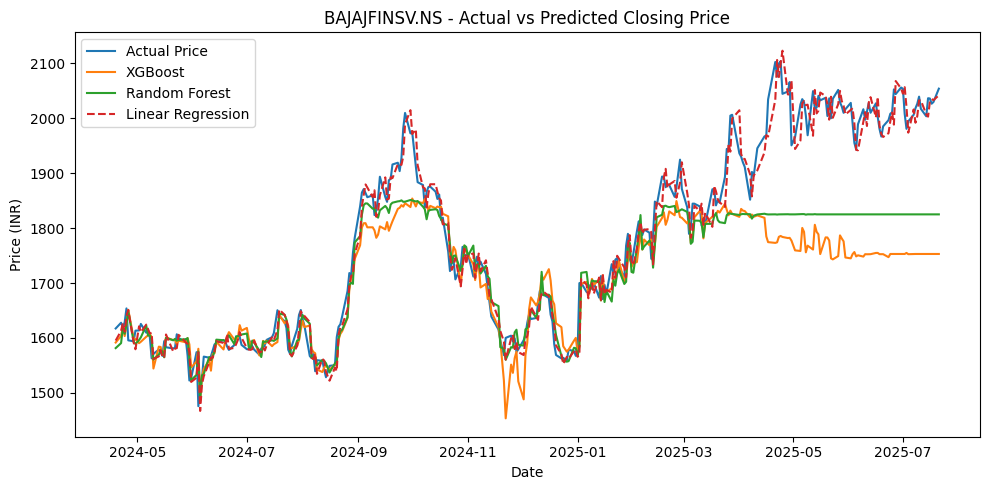

In [ ]:
#Visualization for BAJAJFINSV.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['BAJAJFINSV.NS']['Dates'], PLOTS['BAJAJFINSV.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['BAJAJFINSV.NS']['Dates'], PLOTS['BAJAJFINSV.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['BAJAJFINSV.NS']['Dates'], PLOTS['BAJAJFINSV.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['BAJAJFINSV.NS']['Dates'], PLOTS['BAJAJFINSV.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("BAJAJFINSV.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



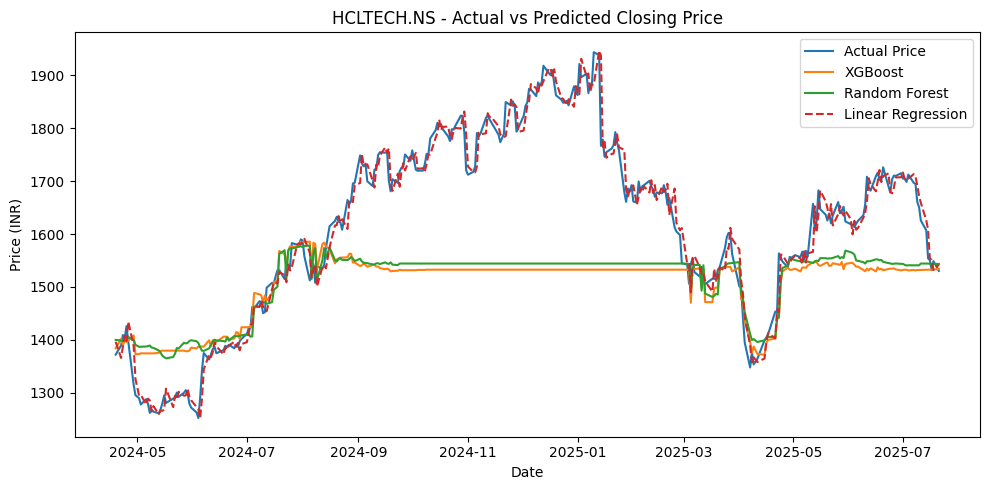

In [ ]:
#Visualization for HCLTECH.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['HCLTECH.NS']['Dates'], PLOTS['HCLTECH.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['HCLTECH.NS']['Dates'], PLOTS['HCLTECH.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['HCLTECH.NS']['Dates'], PLOTS['HCLTECH.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['HCLTECH.NS']['Dates'], PLOTS['HCLTECH.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("HCLTECH.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



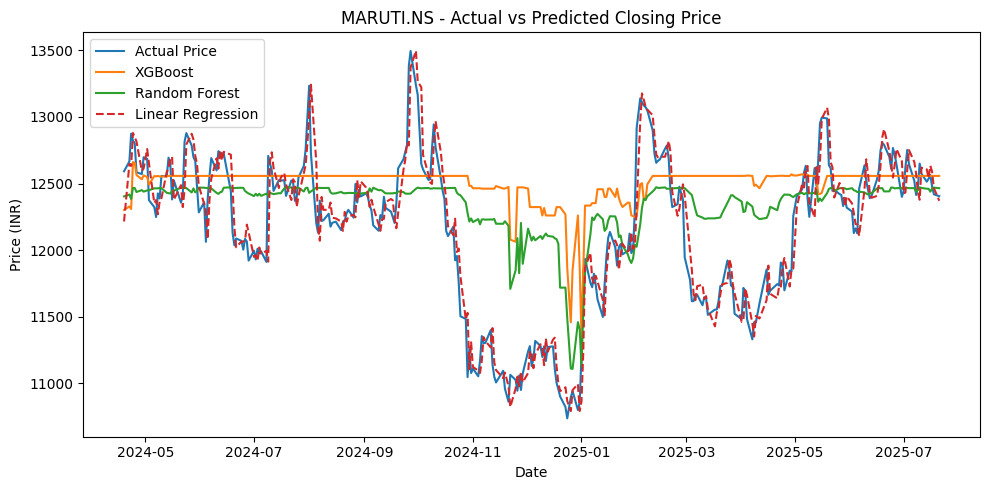

In [ ]:
#Visualization for MARUTI.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['MARUTI.NS']['Dates'], PLOTS['MARUTI.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['MARUTI.NS']['Dates'], PLOTS['MARUTI.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['MARUTI.NS']['Dates'], PLOTS['MARUTI.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['MARUTI.NS']['Dates'], PLOTS['MARUTI.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("MARUTI.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



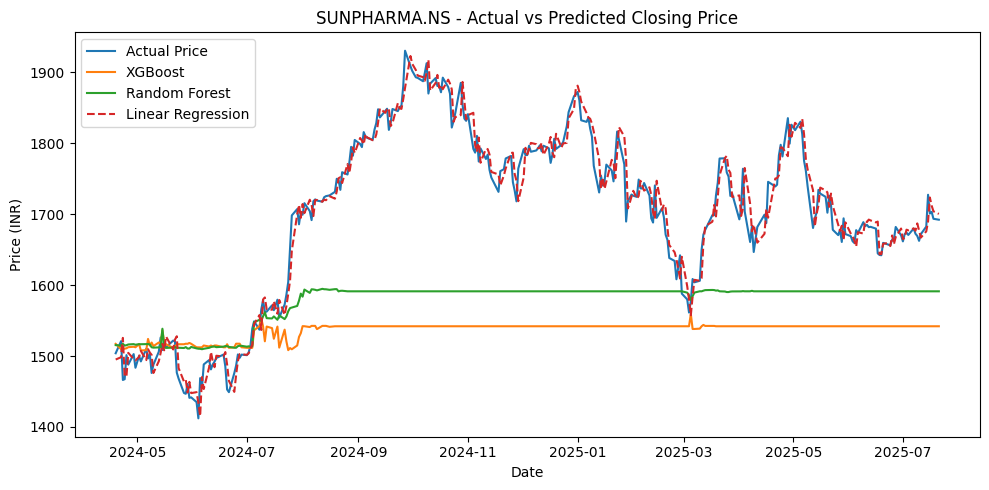

In [ ]:
#Visualization for SUNPHARMA.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['SUNPHARMA.NS']['Dates'], PLOTS['SUNPHARMA.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['SUNPHARMA.NS']['Dates'], PLOTS['SUNPHARMA.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['SUNPHARMA.NS']['Dates'], PLOTS['SUNPHARMA.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['SUNPHARMA.NS']['Dates'], PLOTS['SUNPHARMA.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("SUNPHARMA.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



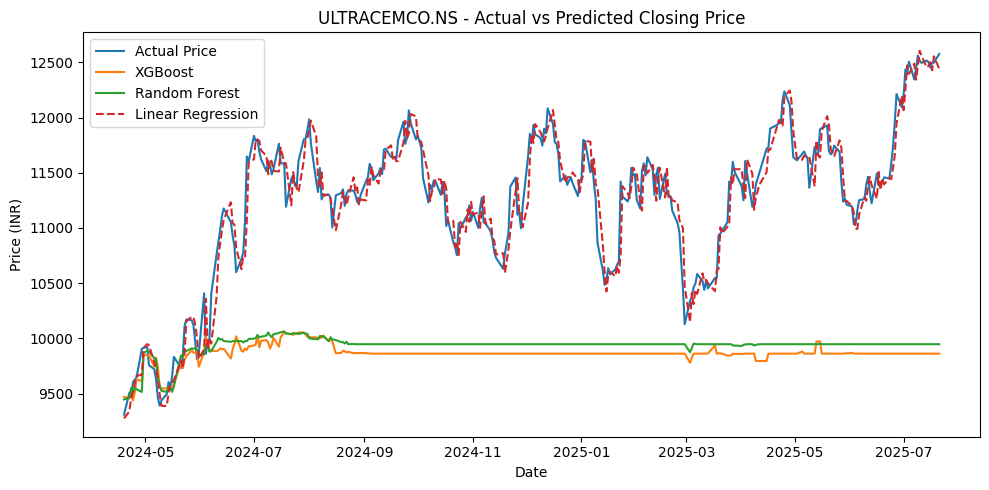

In [ ]:
#Visualization for ULTRACEMCO.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['ULTRACEMCO.NS']['Dates'], PLOTS['ULTRACEMCO.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['ULTRACEMCO.NS']['Dates'], PLOTS['ULTRACEMCO.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['ULTRACEMCO.NS']['Dates'], PLOTS['ULTRACEMCO.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['ULTRACEMCO.NS']['Dates'], PLOTS['ULTRACEMCO.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("ULTRACEMCO.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



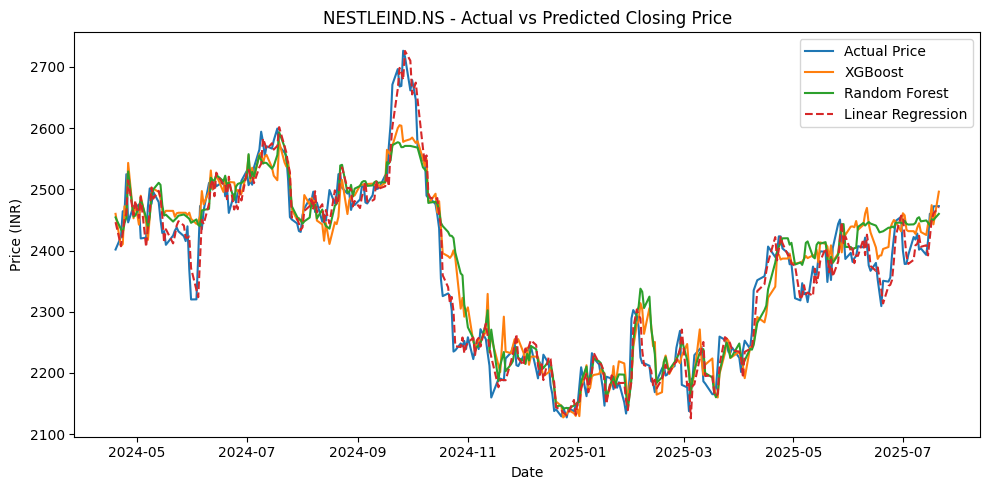

In [ ]:
#Visualization for NESTLEIND.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['NESTLEIND.NS']['Dates'], PLOTS['NESTLEIND.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['NESTLEIND.NS']['Dates'], PLOTS['NESTLEIND.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['NESTLEIND.NS']['Dates'], PLOTS['NESTLEIND.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['NESTLEIND.NS']['Dates'], PLOTS['NESTLEIND.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("NESTLEIND.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



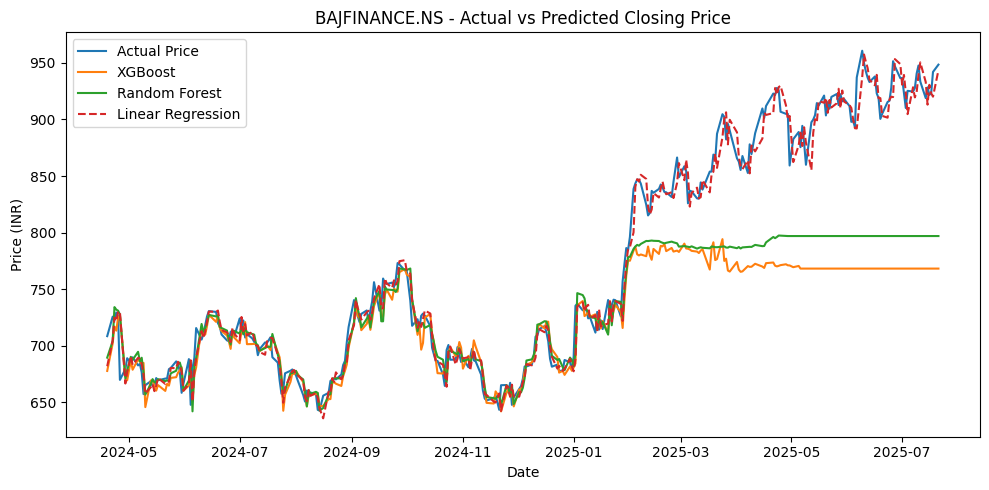

In [ ]:
#Visualization for BAJFINANCE.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['BAJFINANCE.NS']['Dates'], PLOTS['BAJFINANCE.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['BAJFINANCE.NS']['Dates'], PLOTS['BAJFINANCE.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['BAJFINANCE.NS']['Dates'], PLOTS['BAJFINANCE.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['BAJFINANCE.NS']['Dates'], PLOTS['BAJFINANCE.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("BAJFINANCE.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



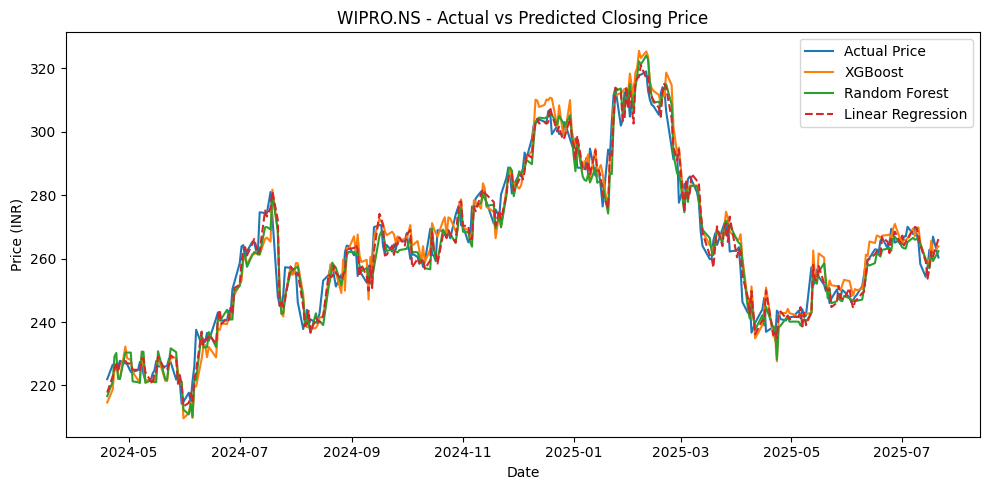

In [ ]:
#Visualization for WIPRO.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['WIPRO.NS']['Dates'], PLOTS['WIPRO.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['WIPRO.NS']['Dates'], PLOTS['WIPRO.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['WIPRO.NS']['Dates'], PLOTS['WIPRO.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['WIPRO.NS']['Dates'], PLOTS['WIPRO.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("WIPRO.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



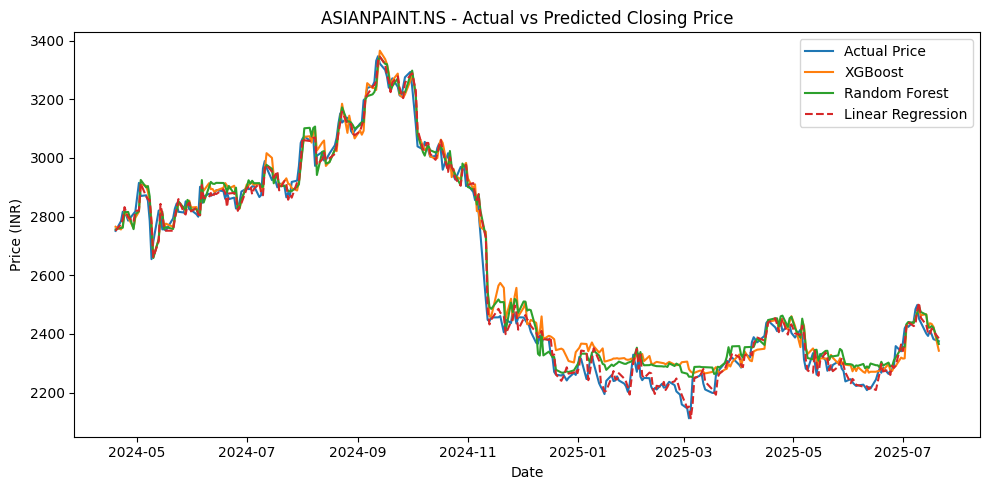

In [ ]:
#Visualization for ASIANPAINT.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['ASIANPAINT.NS']['Dates'], PLOTS['ASIANPAINT.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['ASIANPAINT.NS']['Dates'], PLOTS['ASIANPAINT.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['ASIANPAINT.NS']['Dates'], PLOTS['ASIANPAINT.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['ASIANPAINT.NS']['Dates'], PLOTS['ASIANPAINT.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("ASIANPAINT.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



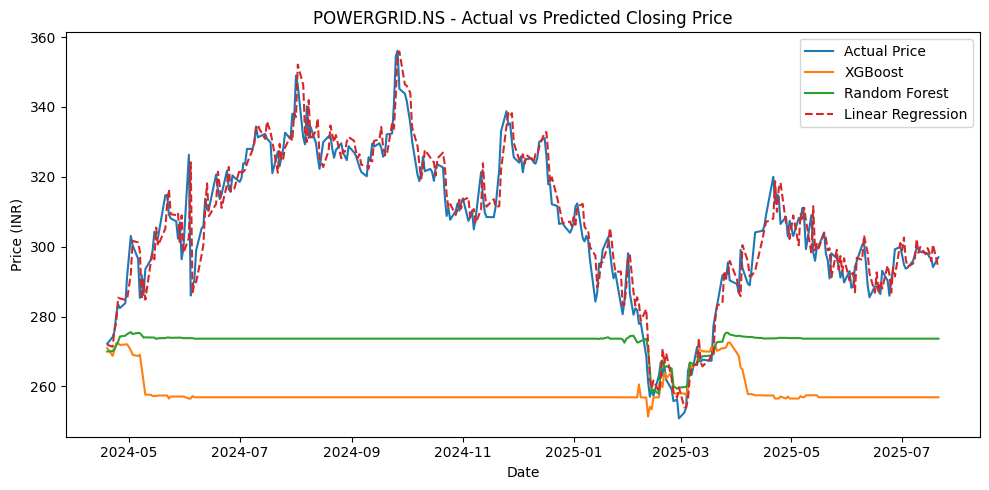

In [ ]:
#Visualization for POWERGRID.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['POWERGRID.NS']['Dates'], PLOTS['POWERGRID.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['POWERGRID.NS']['Dates'], PLOTS['POWERGRID.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['POWERGRID.NS']['Dates'], PLOTS['POWERGRID.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['POWERGRID.NS']['Dates'], PLOTS['POWERGRID.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("POWERGRID.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

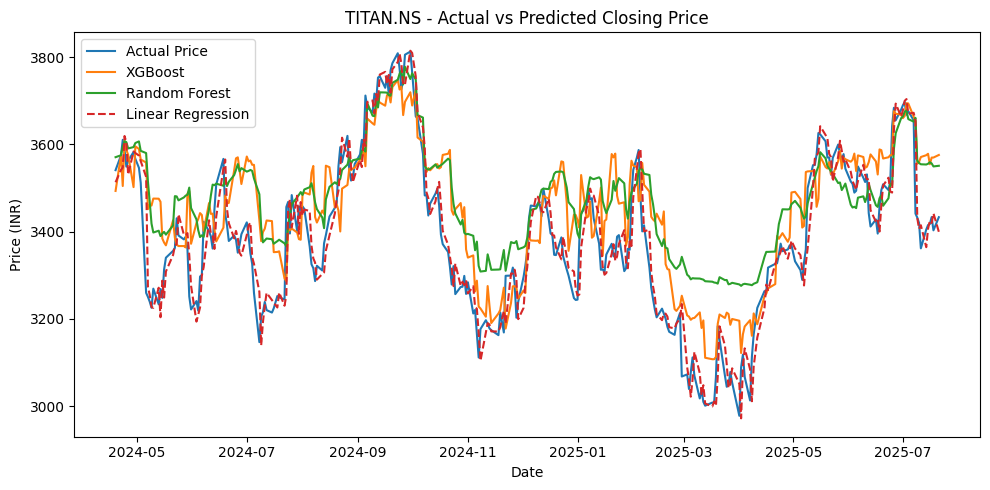

In [ ]:
#Visualization for TITAN.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['TITAN.NS']['Dates'], PLOTS['TITAN.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['TITAN.NS']['Dates'], PLOTS['TITAN.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['TITAN.NS']['Dates'], PLOTS['TITAN.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['TITAN.NS']['Dates'], PLOTS['TITAN.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("TITAN.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

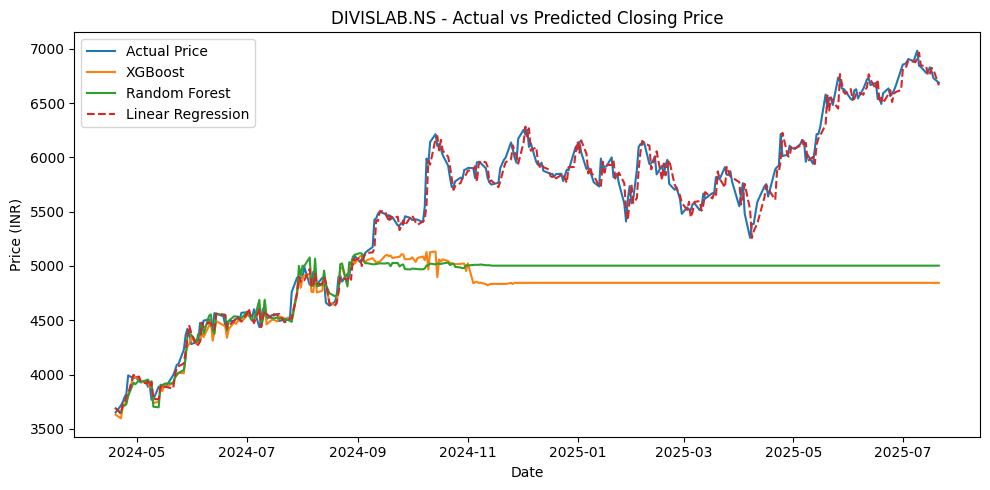

In [ ]:
#Visualization for DIVISLAB.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['DIVISLAB.NS']['Dates'], PLOTS['DIVISLAB.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['DIVISLAB.NS']['Dates'], PLOTS['DIVISLAB.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['DIVISLAB.NS']['Dates'], PLOTS['DIVISLAB.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['DIVISLAB.NS']['Dates'], PLOTS['DIVISLAB.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("DIVISLAB.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

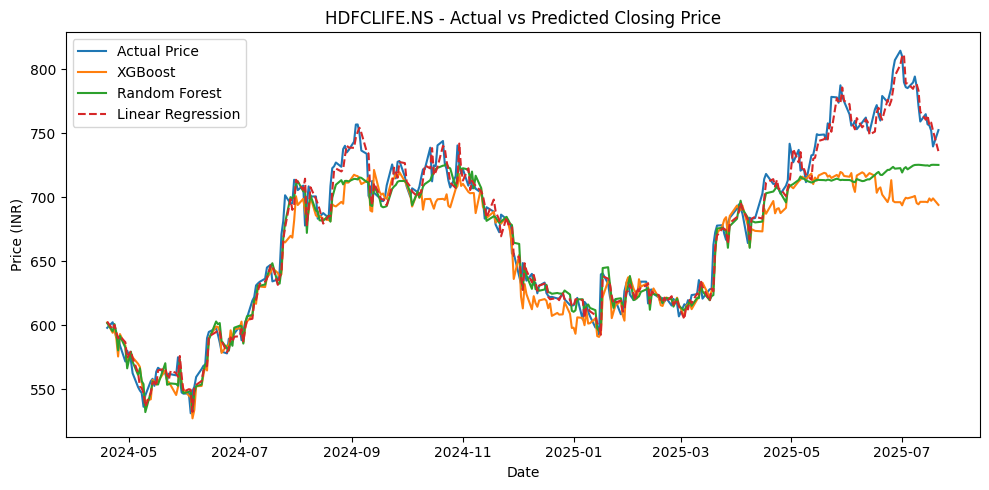

In [ ]:
#Visualization for HDFCLIFE.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['HDFCLIFE.NS']['Dates'], PLOTS['HDFCLIFE.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['HDFCLIFE.NS']['Dates'], PLOTS['HDFCLIFE.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['HDFCLIFE.NS']['Dates'], PLOTS['HDFCLIFE.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['HDFCLIFE.NS']['Dates'], PLOTS['HDFCLIFE.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("HDFCLIFE.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

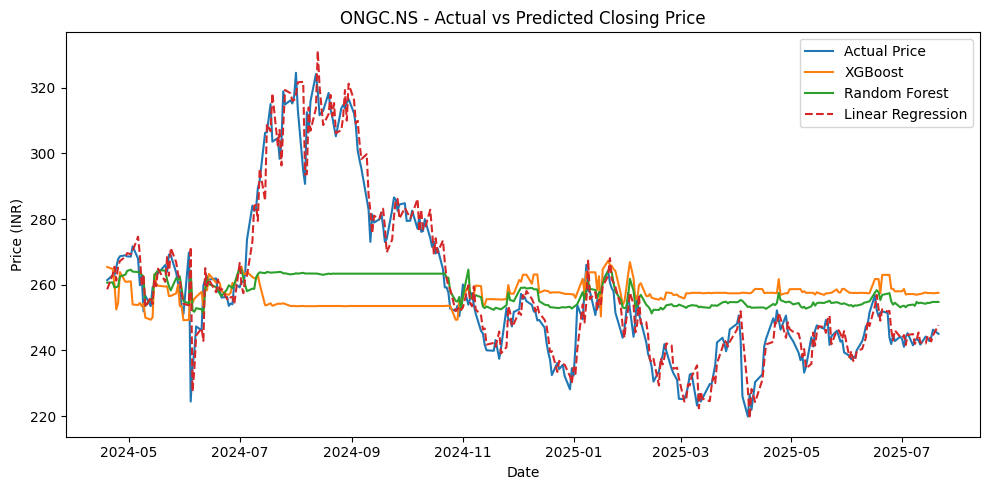

In [ ]:
#Visualization for ONGC.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['ONGC.NS']['Dates'], PLOTS['ONGC.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['ONGC.NS']['Dates'], PLOTS['ONGC.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['ONGC.NS']['Dates'], PLOTS['ONGC.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['ONGC.NS']['Dates'], PLOTS['ONGC.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("ONGC.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

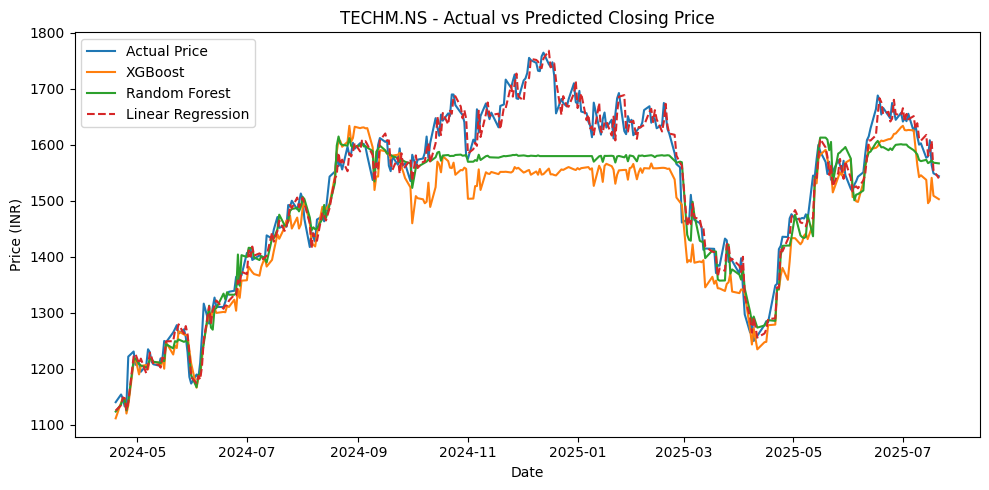

In [ ]:
#Visualization for TECHM.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['TECHM.NS']['Dates'], PLOTS['TECHM.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['TECHM.NS']['Dates'], PLOTS['TECHM.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['TECHM.NS']['Dates'], PLOTS['TECHM.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['TECHM.NS']['Dates'], PLOTS['TECHM.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("TECHM.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



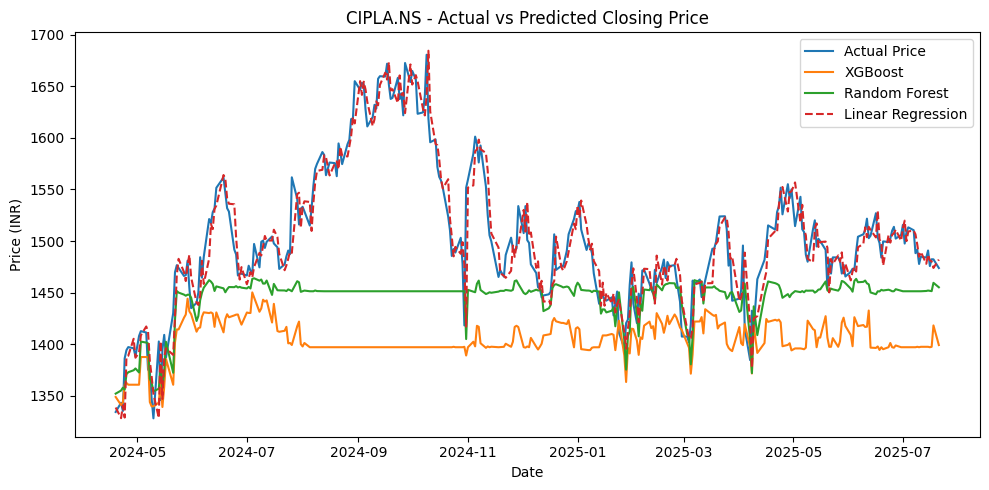

In [ ]:
#Visualization for CIPLA.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['CIPLA.NS']['Dates'], PLOTS['CIPLA.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['CIPLA.NS']['Dates'], PLOTS['CIPLA.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['CIPLA.NS']['Dates'], PLOTS['CIPLA.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['CIPLA.NS']['Dates'], PLOTS['CIPLA.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("CIPLA.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()



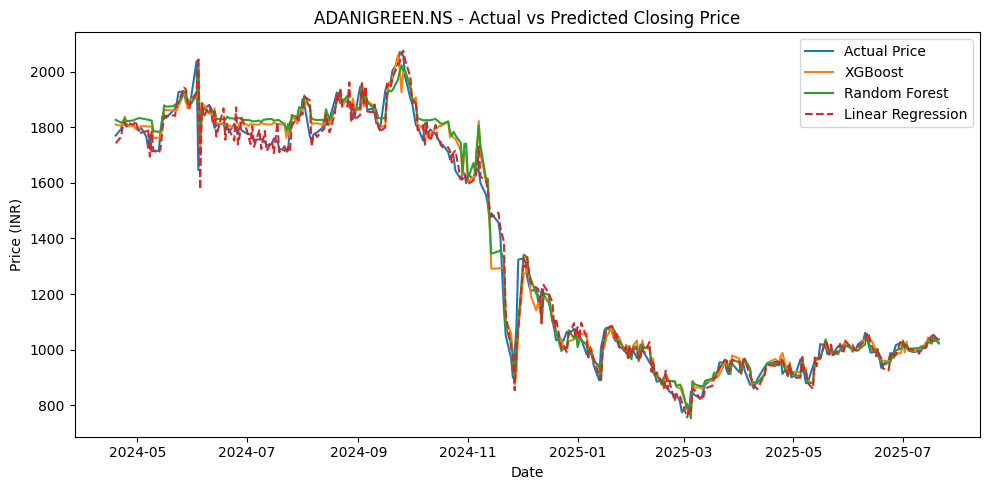

In [ ]:
#Visualization for ADANIGREEN.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['ADANIGREEN.NS']['Dates'], PLOTS['ADANIGREEN.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['ADANIGREEN.NS']['Dates'], PLOTS['ADANIGREEN.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['ADANIGREEN.NS']['Dates'], PLOTS['ADANIGREEN.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['ADANIGREEN.NS']['Dates'], PLOTS['ADANIGREEN.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("ADANIGREEN.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

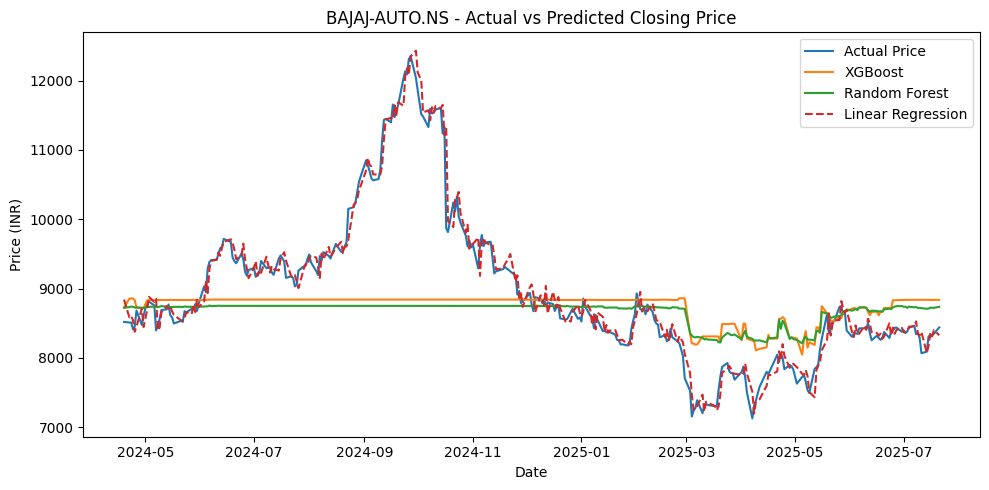

In [ ]:
#Visualization for BAJAJ-AUTO.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['BAJAJ-AUTO.NS']['Dates'], PLOTS['BAJAJ-AUTO.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['BAJAJ-AUTO.NS']['Dates'], PLOTS['BAJAJ-AUTO.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['BAJAJ-AUTO.NS']['Dates'], PLOTS['BAJAJ-AUTO.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['BAJAJ-AUTO.NS']['Dates'], PLOTS['BAJAJ-AUTO.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("BAJAJ-AUTO.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

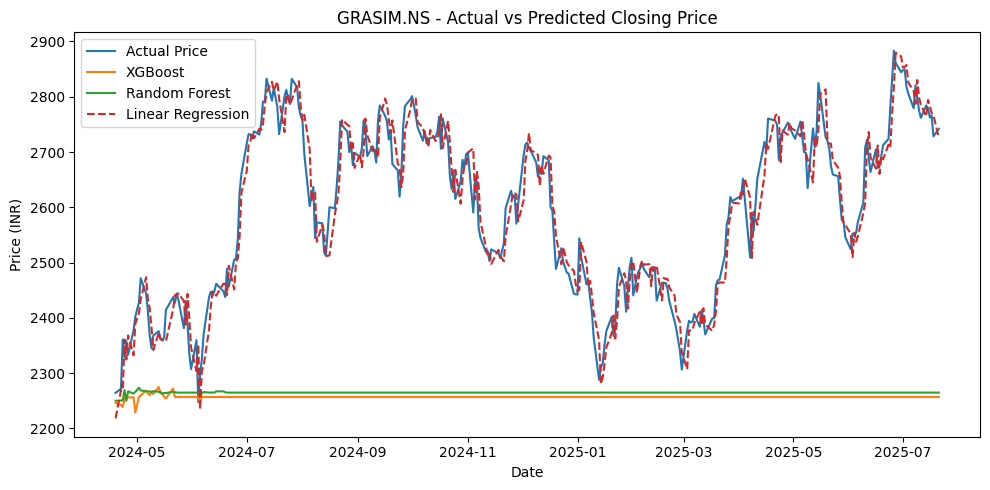

In [ ]:
#Visualization for GRASIM.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['GRASIM.NS']['Dates'], PLOTS['GRASIM.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['GRASIM.NS']['Dates'], PLOTS['GRASIM.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['GRASIM.NS']['Dates'], PLOTS['GRASIM.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['GRASIM.NS']['Dates'], PLOTS['GRASIM.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("GRASIM.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

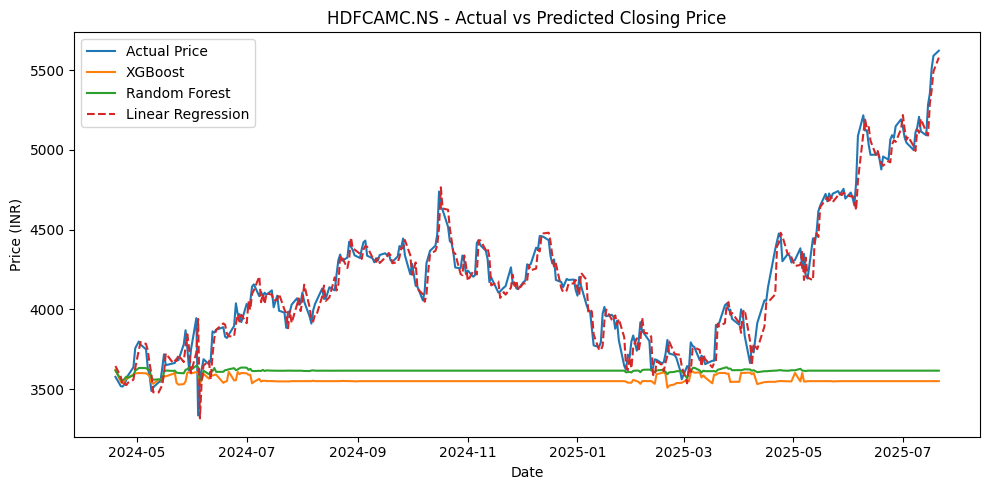

In [ ]:
#Visualization for HDFCAMC.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['HDFCAMC.NS']['Dates'], PLOTS['HDFCAMC.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['HDFCAMC.NS']['Dates'], PLOTS['HDFCAMC.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['HDFCAMC.NS']['Dates'], PLOTS['HDFCAMC.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['HDFCAMC.NS']['Dates'], PLOTS['HDFCAMC.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("HDFCAMC.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

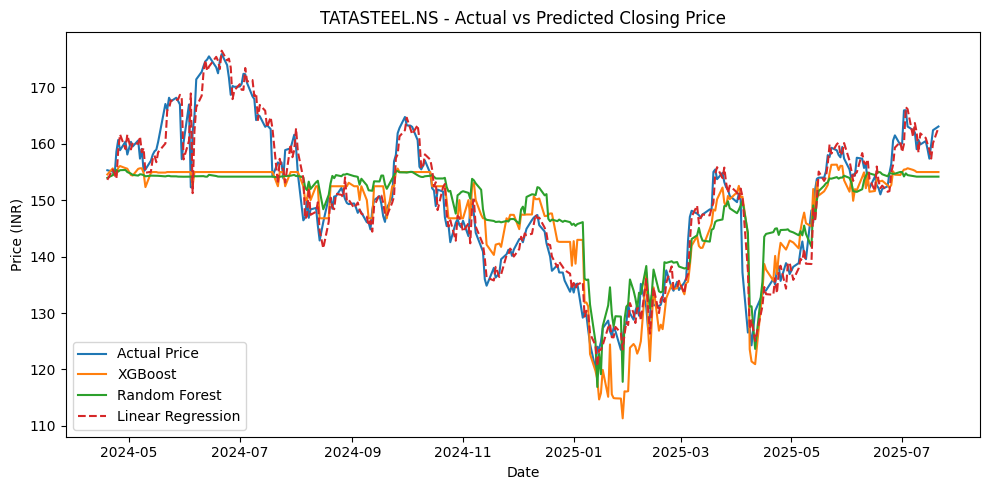

In [ ]:
#Visualization for TATASTEEL.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['TATASTEEL.NS']['Dates'], PLOTS['TATASTEEL.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['TATASTEEL.NS']['Dates'], PLOTS['TATASTEEL.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['TATASTEEL.NS']['Dates'], PLOTS['TATASTEEL.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['TATASTEEL.NS']['Dates'], PLOTS['TATASTEEL.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("TATASTEEL.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

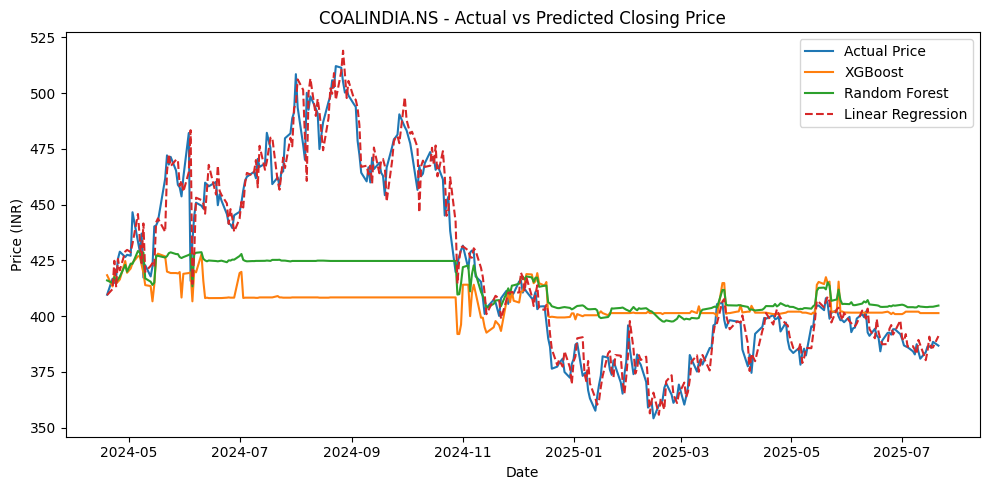

In [ ]:
#Visualization for COALINDIA.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['COALINDIA.NS']['Dates'], PLOTS['COALINDIA.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['COALINDIA.NS']['Dates'], PLOTS['COALINDIA.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['COALINDIA.NS']['Dates'], PLOTS['COALINDIA.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['COALINDIA.NS']['Dates'], PLOTS['COALINDIA.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("COALINDIA.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

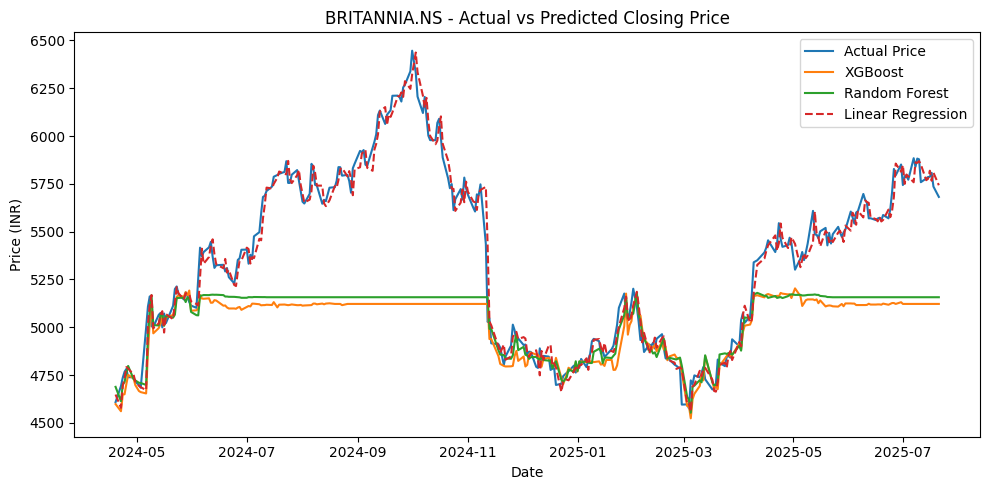

In [ ]:
#Visualization for BRITANNIA.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['BRITANNIA.NS']['Dates'], PLOTS['BRITANNIA.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['BRITANNIA.NS']['Dates'], PLOTS['BRITANNIA.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['BRITANNIA.NS']['Dates'], PLOTS['BRITANNIA.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['BRITANNIA.NS']['Dates'], PLOTS['BRITANNIA.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("BRITANNIA.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

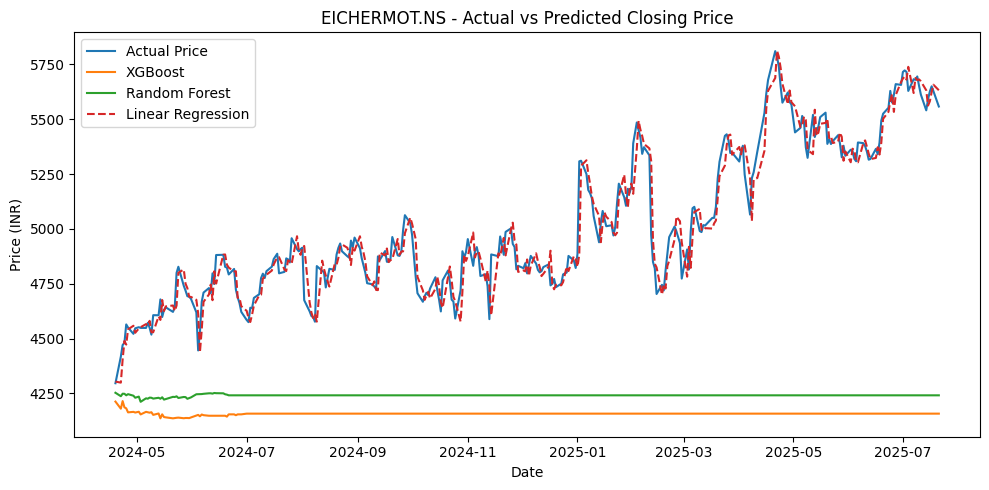

In [ ]:
#Visualization for EICHERMOT.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['EICHERMOT.NS']['Dates'], PLOTS['EICHERMOT.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['EICHERMOT.NS']['Dates'], PLOTS['EICHERMOT.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['EICHERMOT.NS']['Dates'], PLOTS['EICHERMOT.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['EICHERMOT.NS']['Dates'], PLOTS['EICHERMOT.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("EICHERMOT.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

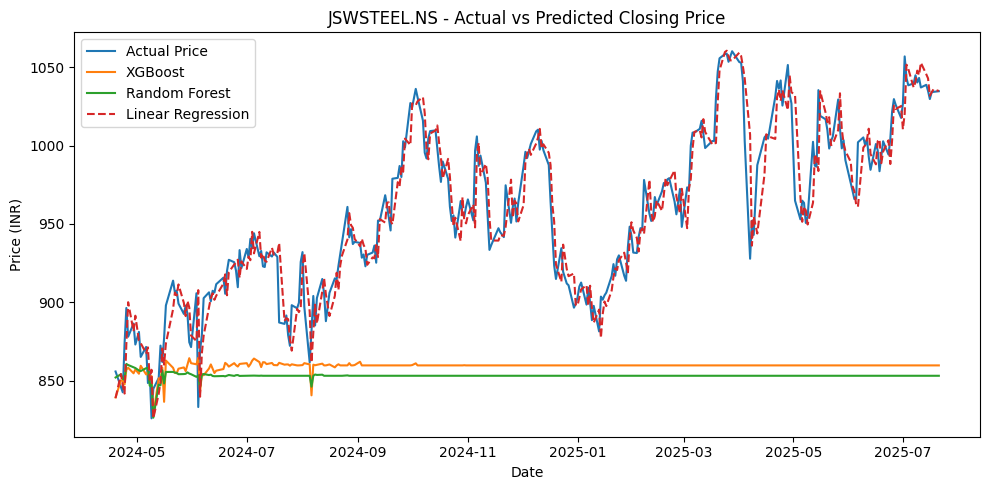

In [ ]:
#Visualization for JSWSTEEL.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['JSWSTEEL.NS']['Dates'], PLOTS['JSWSTEEL.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['JSWSTEEL.NS']['Dates'], PLOTS['JSWSTEEL.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['JSWSTEEL.NS']['Dates'], PLOTS['JSWSTEEL.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['JSWSTEEL.NS']['Dates'], PLOTS['JSWSTEEL.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("JSWSTEEL.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

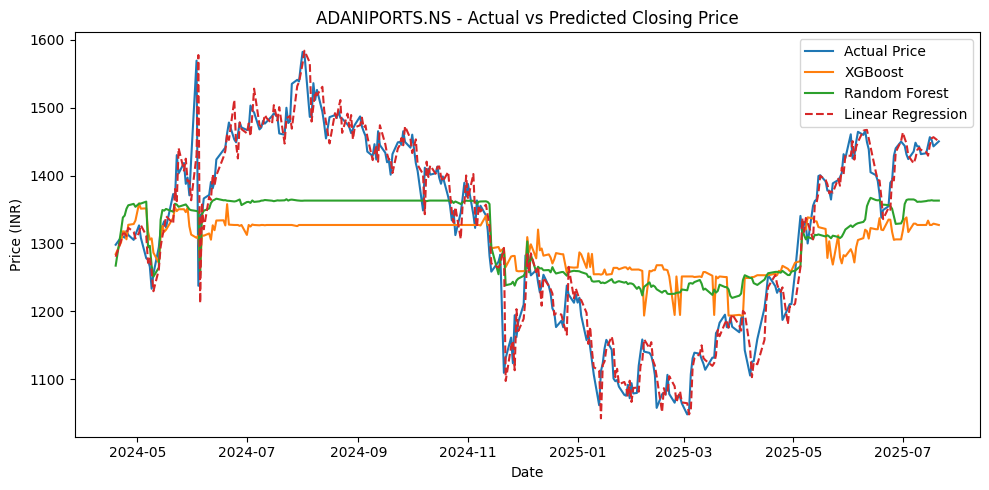

In [ ]:
#Visualization for ADANIPORTS.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['ADANIPORTS.NS']['Dates'], PLOTS['ADANIPORTS.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['ADANIPORTS.NS']['Dates'], PLOTS['ADANIPORTS.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['ADANIPORTS.NS']['Dates'], PLOTS['ADANIPORTS.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['ADANIPORTS.NS']['Dates'], PLOTS['ADANIPORTS.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("ADANIPORTS.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

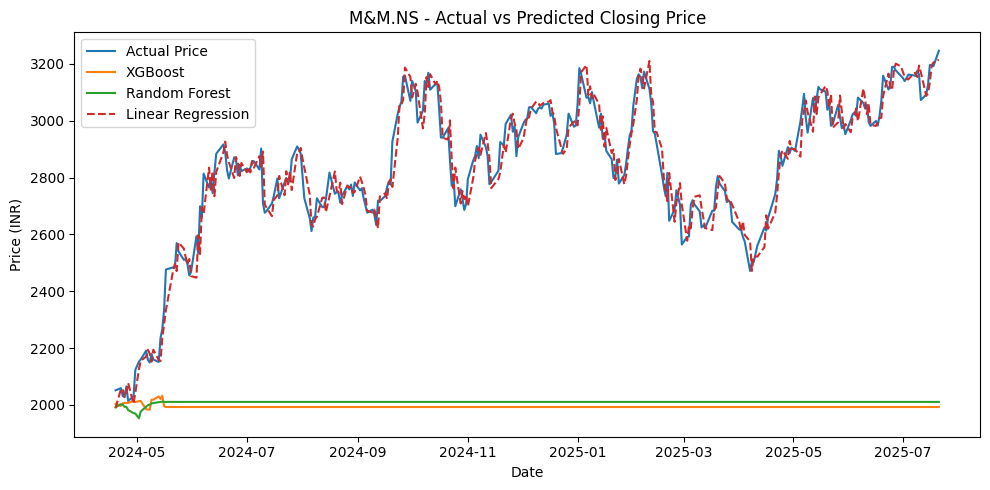

In [ ]:
#Visualization for M&M.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['M&M.NS']['Dates'], PLOTS['M&M.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['M&M.NS']['Dates'], PLOTS['M&M.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['M&M.NS']['Dates'], PLOTS['M&M.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['M&M.NS']['Dates'], PLOTS['M&M.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("M&M.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

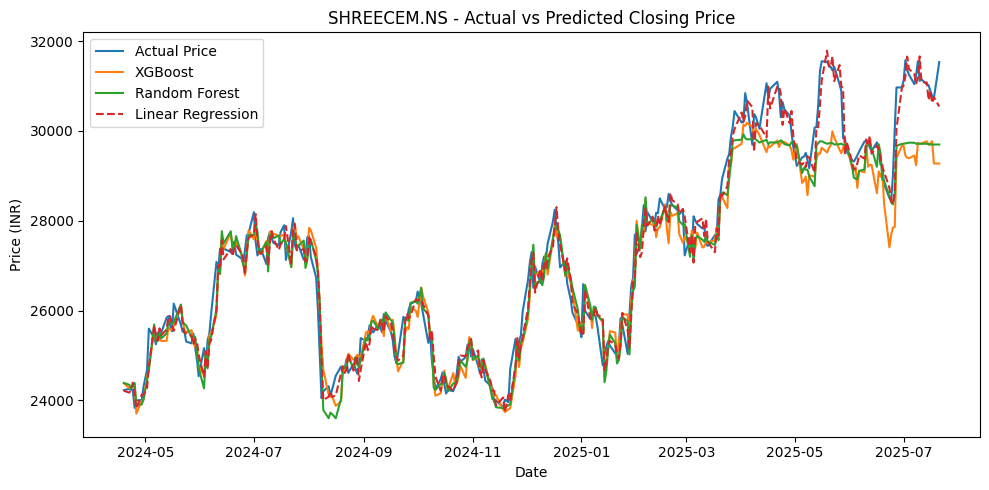

In [ ]:
#Visualization for SHREECEM.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['SHREECEM.NS']['Dates'], PLOTS['SHREECEM.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['SHREECEM.NS']['Dates'], PLOTS['SHREECEM.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['SHREECEM.NS']['Dates'], PLOTS['SHREECEM.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['SHREECEM.NS']['Dates'], PLOTS['SHREECEM.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("SHREECEM.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

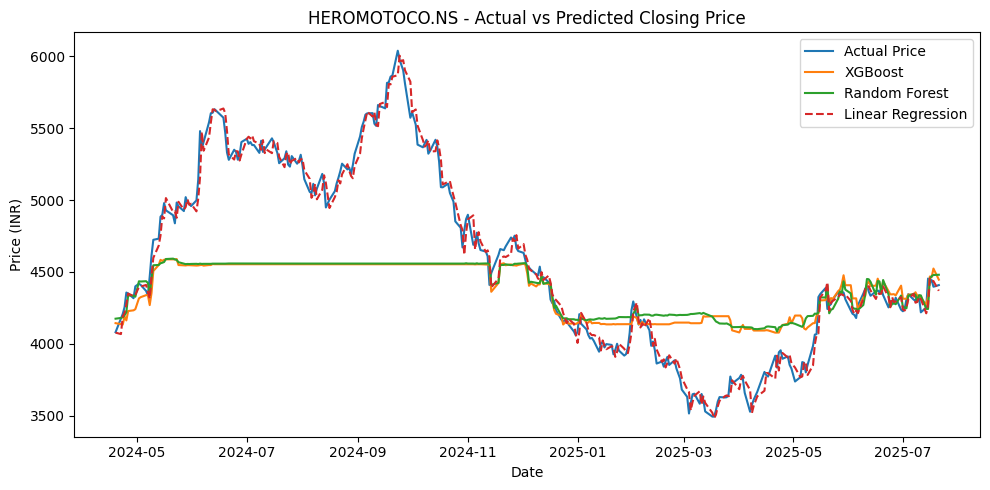

In [ ]:
#Visualization for HEROMOTOCO.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['HEROMOTOCO.NS']['Dates'], PLOTS['HEROMOTOCO.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['HEROMOTOCO.NS']['Dates'], PLOTS['HEROMOTOCO.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['HEROMOTOCO.NS']['Dates'], PLOTS['HEROMOTOCO.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['HEROMOTOCO.NS']['Dates'], PLOTS['HEROMOTOCO.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("HEROMOTOCO.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

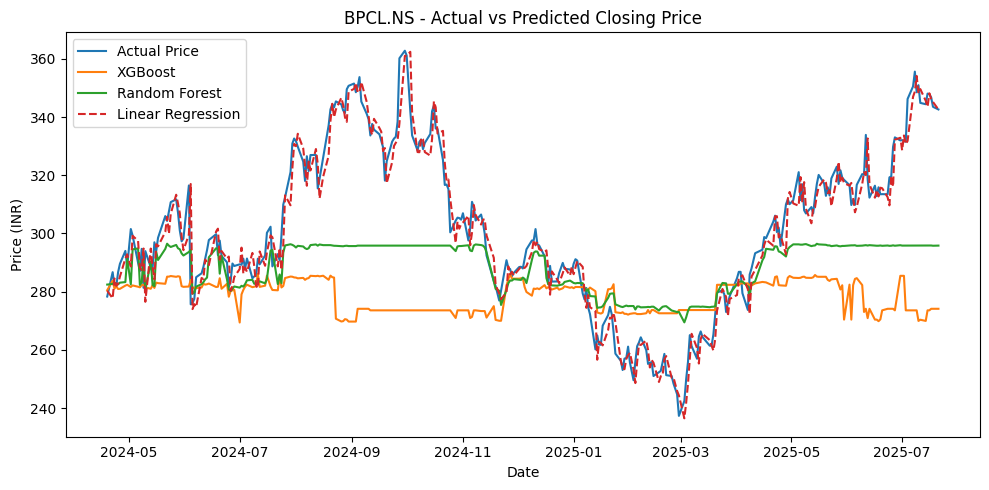

In [ ]:
#Visualization for BPCL.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['BPCL.NS']['Dates'], PLOTS['BPCL.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['BPCL.NS']['Dates'], PLOTS['BPCL.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['BPCL.NS']['Dates'], PLOTS['BPCL.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['BPCL.NS']['Dates'], PLOTS['BPCL.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("BPCL.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

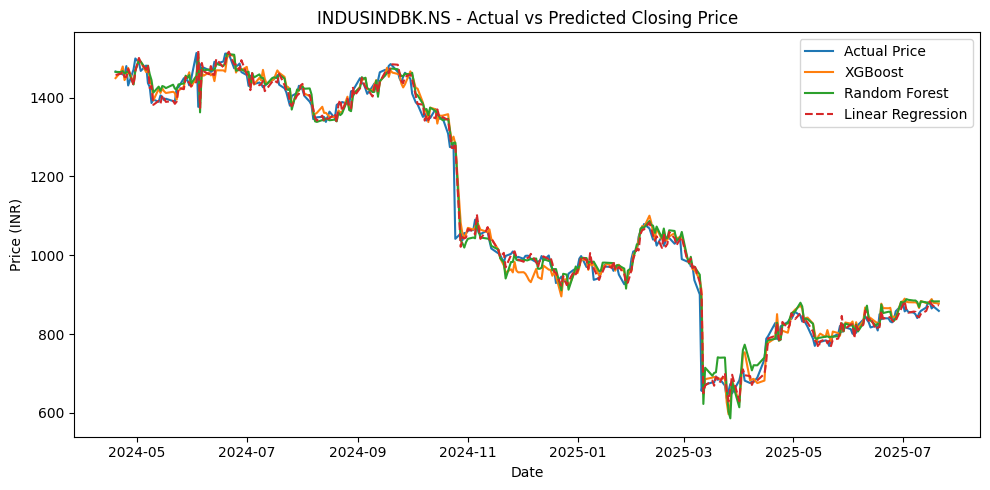

In [ ]:
#Visualization for INDUSINDBK.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['INDUSINDBK.NS']['Dates'], PLOTS['INDUSINDBK.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['INDUSINDBK.NS']['Dates'], PLOTS['INDUSINDBK.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['INDUSINDBK.NS']['Dates'], PLOTS['INDUSINDBK.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['INDUSINDBK.NS']['Dates'], PLOTS['INDUSINDBK.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("INDUSINDBK.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

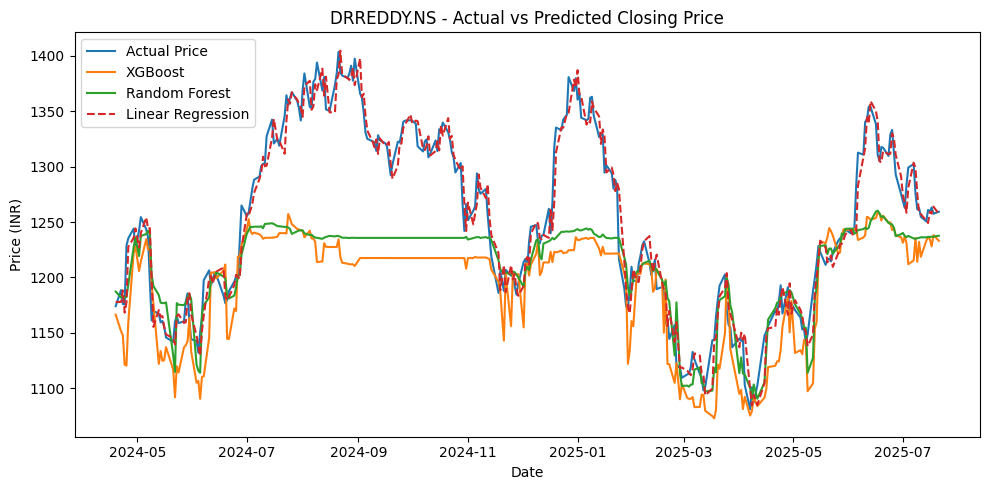

In [ ]:
#Visualization for DRREDDY.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['DRREDDY.NS']['Dates'], PLOTS['DRREDDY.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['DRREDDY.NS']['Dates'], PLOTS['DRREDDY.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['DRREDDY.NS']['Dates'], PLOTS['DRREDDY.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['DRREDDY.NS']['Dates'], PLOTS['DRREDDY.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("DRREDDY.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

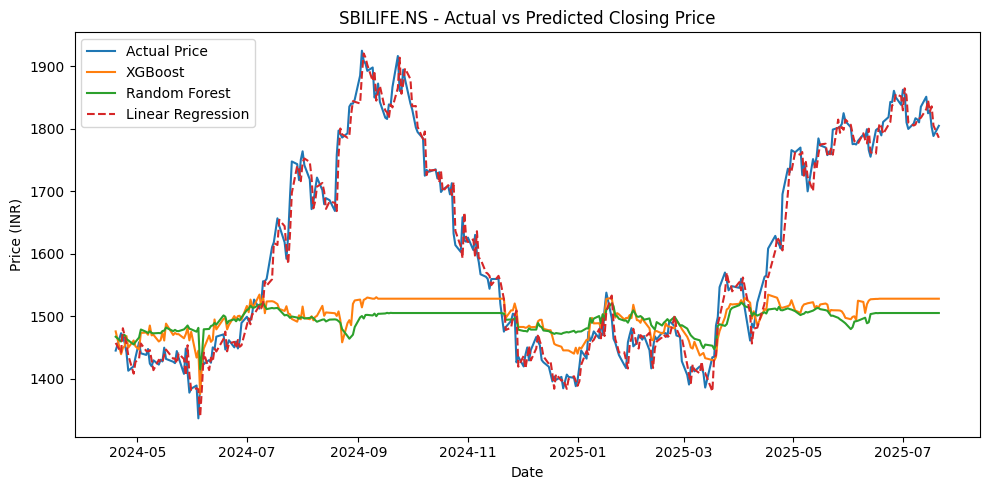

In [ ]:
#Visualization for SBILIFE.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['SBILIFE.NS']['Dates'], PLOTS['SBILIFE.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['SBILIFE.NS']['Dates'], PLOTS['SBILIFE.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['SBILIFE.NS']['Dates'], PLOTS['SBILIFE.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['SBILIFE.NS']['Dates'], PLOTS['SBILIFE.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("SBILIFE.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

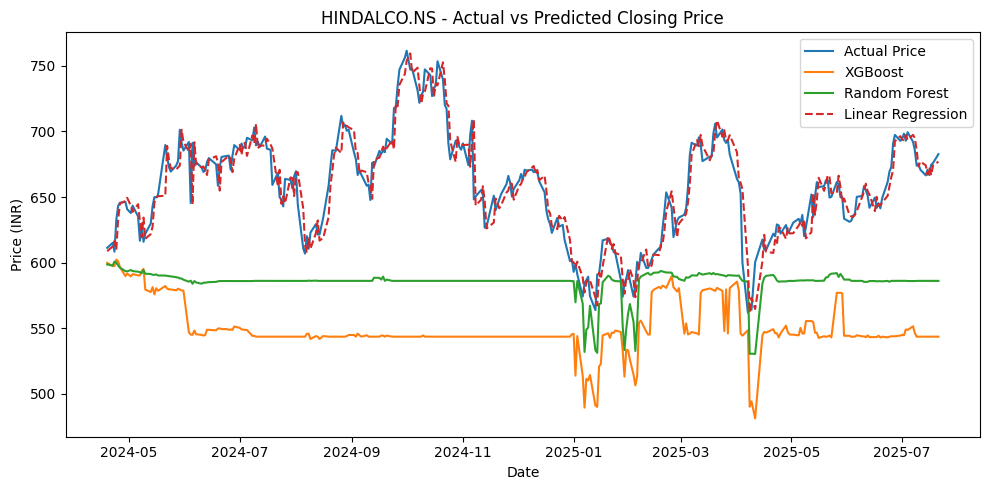

In [ ]:
#Visualization for HINDALCO.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['HINDALCO.NS']['Dates'], PLOTS['HINDALCO.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['HINDALCO.NS']['Dates'], PLOTS['HINDALCO.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['HINDALCO.NS']['Dates'], PLOTS['HINDALCO.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['HINDALCO.NS']['Dates'], PLOTS['HINDALCO.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("HINDALCO.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

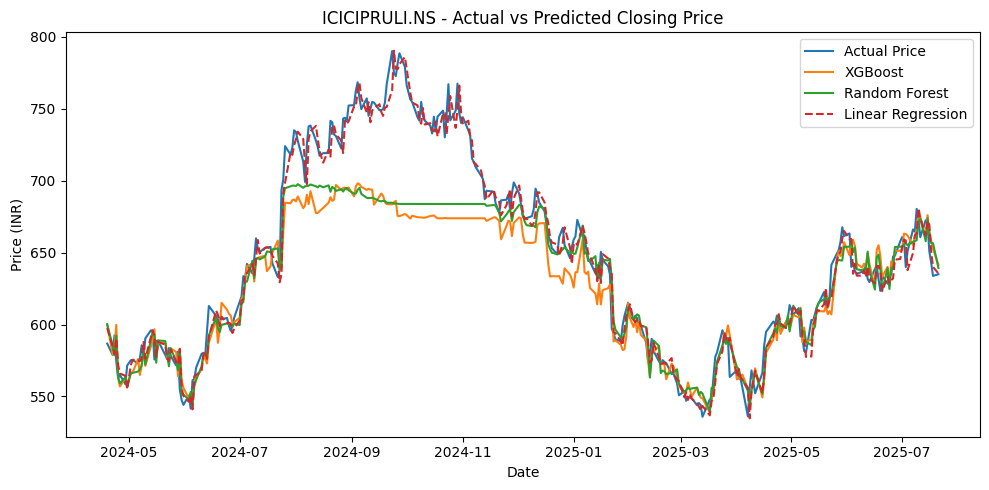

In [ ]:
#Visualization for ICICIPRULI.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['ICICIPRULI.NS']['Dates'], PLOTS['ICICIPRULI.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['ICICIPRULI.NS']['Dates'], PLOTS['ICICIPRULI.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['ICICIPRULI.NS']['Dates'], PLOTS['ICICIPRULI.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['ICICIPRULI.NS']['Dates'], PLOTS['ICICIPRULI.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("ICICIPRULI.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

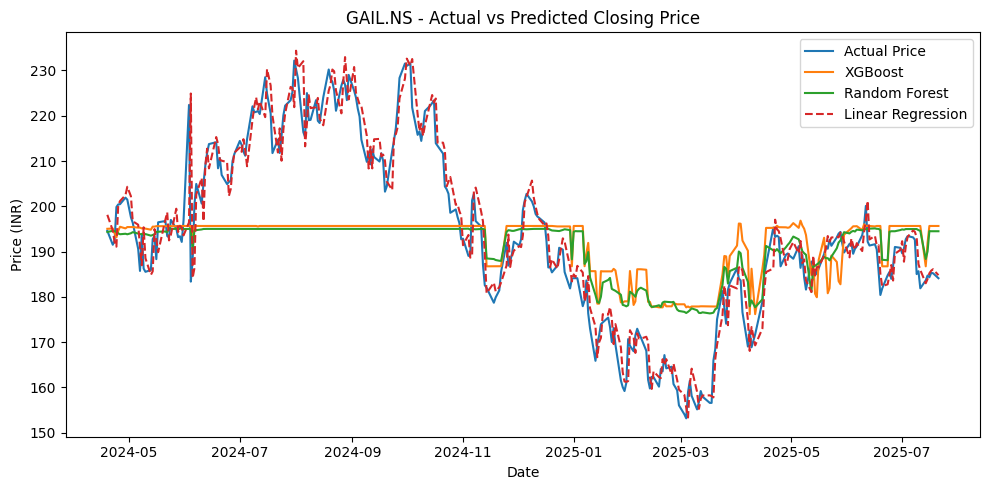

In [ ]:
#Visualization for GAIL.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['GAIL.NS']['Dates'], PLOTS['GAIL.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['GAIL.NS']['Dates'], PLOTS['GAIL.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['GAIL.NS']['Dates'], PLOTS['GAIL.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['GAIL.NS']['Dates'], PLOTS['GAIL.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("GAIL.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

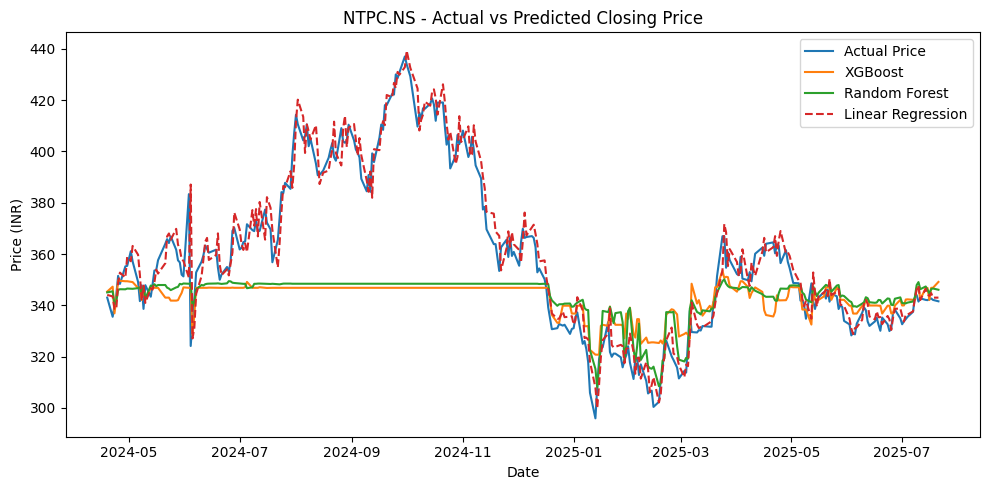

In [ ]:
#Visualization for NTPC.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['NTPC.NS']['Dates'], PLOTS['NTPC.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['NTPC.NS']['Dates'], PLOTS['NTPC.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['NTPC.NS']['Dates'], PLOTS['NTPC.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['NTPC.NS']['Dates'], PLOTS['NTPC.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("NTPC.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

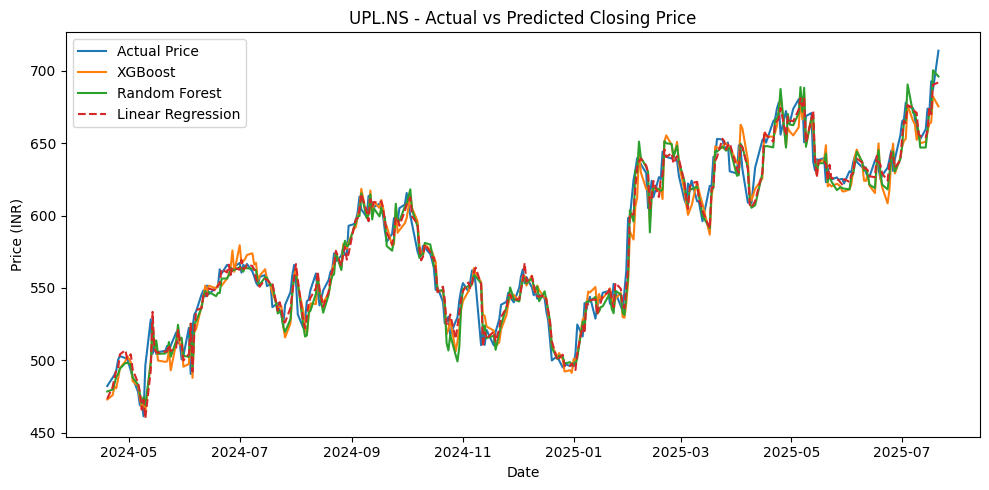

In [ ]:
#Visualization for UPL.NS
plt.figure(figsize=(10,5))
plt.plot(PLOTS['UPL.NS']['Dates'], PLOTS['UPL.NS']['Actual'], label='Actual Price')
plt.plot(PLOTS['UPL.NS']['Dates'], PLOTS['UPL.NS']['XGB_Pred'], label='XGBoost')
plt.plot(PLOTS['UPL.NS']['Dates'], PLOTS['UPL.NS']['RF_Pred'], label='Random Forest')
plt.plot(PLOTS['UPL.NS']['Dates'], PLOTS['UPL.NS']['LR_Pred'], label='Linear Regression', linestyle='--')
plt.title("UPL.NS - Actual vs Predicted Closing Price")
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
results_df = pd.DataFrame(results)
print("\n==== Model Performance Summary (RMSE) ====")
print(results_df[['Ticker', 'RMSE_XGB', 'RMSE_RF', 'RMSE_LR', 'Best_Model']])
print(f"\nCount of best model per stock:\n{results_df['Best_Model'].value_counts()}")

print("""
Takeaway:
---------
- XGBoost and tree-based models are often more accurate for stock price forecasting with this setup.
- This script uses the latest available data for all stocks and visualizes predictions for individual Nifty 50 stocks.
- To plot any other stock, just copy one of the blocks above and change the ticker symbol!
""")




==== Model Performance Summary (RMSE) ====
           Ticker     RMSE_XGB      RMSE_RF     RMSE_LR        Best_Model
0     RELIANCE.NS    47.175247    40.377025   19.900879  LinearRegression
1          TCS.NS   211.395056   218.715603   53.731937  LinearRegression
2     HDFCBANK.NS   169.021499   174.481815   22.435001  LinearRegression
3         INFY.NS   109.590852    91.695587   26.397539  LinearRegression
4    ICICIBANK.NS   223.514890   218.856481   16.431076  LinearRegression
5   HINDUNILVR.NS   116.418556    88.832376   32.561638  LinearRegression
6          ITC.NS    25.240721    25.199424    5.366893  LinearRegression
7    KOTAKBANK.NS    61.133794    46.094310   29.808136  LinearRegression
8           LT.NS   102.757392   100.146500   64.319951  LinearRegression
9         SBIN.NS    64.358239    62.367668   14.152708  LinearRegression
10  BHARTIARTL.NS   430.463751   431.313898   23.064602  LinearRegression
11    AXISBANK.NS    86.400681    84.438142   17.919048  LinearRegre